<a href="https://colab.research.google.com/github/edieski/dog-breed-deted/blob/main/pytorch_dog_detec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tarfile
import os
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from torch.utils.data.dataset import TensorDataset, ConcatDataset

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/dog_classification/data/final_classes/')


In [ ]:
os.getcwd()

'/content/drive/MyDrive/dog_classification/data/final_classes'

In [ ]:
os.listdir()

['n02099601-golden_retriever',
 'n02110185-Siberian_husky',
 'n02111277-Newfoundland',
 'n02085936-Maltese_dog',
 'n02086646-Blenheim_spaniel']

In [ ]:
class Dogtaset(Dataset):
  def __init__(self, path, transform):
    self.path =  path
    self.image_path = []
    self.labels = []
    self.label_dict = {


    }


    self.transform = transform
    labels = os.listdir(self.path)

    for i in range(len(labels)):
      self.label_dict[i] = labels[i]
    for i in range(len(self.label_dict)):
      for k in os.listdir(f"{self.path}/{self.label_dict[i]}"):
        self.labels.append(i)
        self.image_path.append(f"{self.path}/{self.label_dict[i]}/{k}")
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
      image = Image.open(self.image_path[idx])
      if self.transform:
        image = self.transform(image)
      return image, torch.tensor(self.labels[idx])



In [ ]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


In [ ]:
DogDataSet = Dogtaset('/content/drive/MyDrive/dog_classification/data/final_classes/', transform = tt.Compose([tt.ToTensor(), tt.Resize((224,224)), tt.Lambda(lambda x: x[:3]), tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

In [ ]:
train_set, val_set = torch.utils.data.random_split(DogDataSet, [0.8, 0.2])


In [ ]:
transform_train = tt.RandomResizedCrop(size = (224, 224), scale = (0.2, 0.8))

In [ ]:
len(train_set)

784

In [ ]:
augmented_set = DatasetFromSubset(train_set, transform=transform_train)
final_trainset = torch.utils.data.ConcatDataset([train_set, augmented_set])

In [ ]:
print(train_set[0][0].shape)

torch.Size([3, 224, 224])


In [ ]:
print(train_set[0][0].shape)

torch.Size([3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


make a grid of train set and augmented se


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


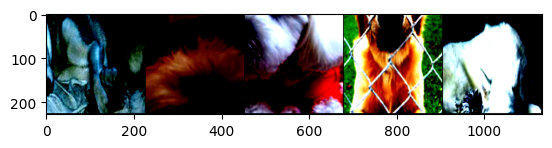

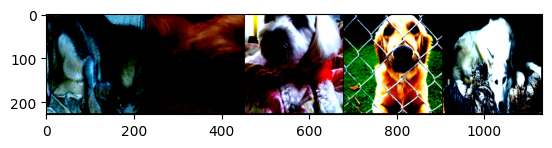

In [ ]:
import random

random_numbers = [random.randint(1, len(augmented_set)) for _ in range(5)]
tensors_aug = [augmented_set[i][0] for i in random_numbers]
tensors = [train_set[i][0] for i in random_numbers]
grid_au = make_grid(tensors_aug)
grid = make_grid(tensors)

plt.imshow(grid_au.permute(1, 2, 0));
plt.show()
plt.imshow(grid.permute(1, 2, 0)) #faire un titre


## Making Data Loaders

In [ ]:
len(final_trainset)

1556

In [ ]:
train_dl = DataLoader(final_trainset, batch_size=32, shuffle=True, drop_last=True)
val_dl = DataLoader(val_set, batch_size=32, shuffle= True)

## Defining the model

Output shape of conv = (W - F + 2P)/S+1

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class convNet(nn.Module):


  def __init__(self):
    super(convNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(6)
    self.pool = nn.MaxPool2d(2, 2) #same output calc as a conv
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.bn2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16, 32, 5)
    self.bn3 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(32*49*49, 10000)
    self.fc2 = nn.Linear(10000, len(DogDataSet.label_dict))


  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.pool(x)
    x = F.relu(self.bn2(self.conv2(x)))
    x = self.pool(x)
    x = F.relu(self.bn3(self.conv3(x)))
    x = x.view(-1, 32*49*49)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

In [ ]:
tensor_size = (16, 3, 224, 224)
test_tensor= torch.ones(tensor_size)

In [ ]:
test_tensor = test_tensor.to(device)

In [ ]:
model = convNet().to(device)

In [ ]:
model(test_tensor).shape

torch.Size([16, 5])

In [ ]:
num_epochs = 300
lr = 0.001
criterion = nn.CrossEntropyLoss() #softmax already included in the cross entropy
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

If you add dropout layers dont forget to call model.eval() before making predictions
Make better = add a lr scheduler


In [ ]:
# get accuracy pred for each epoch and print final accuracy

best_loss = None
n_total_steps = len(train_dl)
for epochs in range(num_epochs):
  for i, (image, labels) in enumerate(train_dl):
    if image.shape[1] == 3:
      image = image.to(device)
      labels = labels.to(device)

      outputs = model(image)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i + 1) % 10 ==0:
        print(f'step {i + 1} out of {n_total_steps} in epoch {epochs+1} out of epochs {num_epochs}, Loss :{loss.item()}')

  print('finished training')









step 10 out of 24 in epoch 1 out of epochs 300, Loss :0.0049274275079369545
step 20 out of 24 in epoch 1 out of epochs 300, Loss :0.004429643042385578
finished training
step 10 out of 24 in epoch 2 out of epochs 300, Loss :0.0034966322127729654
step 20 out of 24 in epoch 2 out of epochs 300, Loss :0.004374905489385128
finished training
step 10 out of 24 in epoch 3 out of epochs 300, Loss :0.0049902102909982204
step 20 out of 24 in epoch 3 out of epochs 300, Loss :0.002927555702626705
finished training
step 10 out of 24 in epoch 4 out of epochs 300, Loss :0.0060319723561406136
step 20 out of 24 in epoch 4 out of epochs 300, Loss :0.004543699324131012
finished training
step 10 out of 24 in epoch 5 out of epochs 300, Loss :0.005849895067512989
step 20 out of 24 in epoch 5 out of epochs 300, Loss :0.007360974792391062
finished training
step 10 out of 24 in epoch 6 out of epochs 300, Loss :0.003332495456561446
step 20 out of 24 in epoch 6 out of epochs 300, Loss :0.004525233991444111
finish

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  n_samples = 0
  n_correct = 0
  n_classes = [0 for i in range(len(DogDataSet.label_dict))]
  n_correct_classes = [0 for i in range(len(DogDataSet.label_dict))]
  for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images) # output of size (batchsize, num of classes)
    _, predicted = torch.max(outputs, dim=1) #max for each of the colums dim=1 columns and we want the indexes not the prob
    n_samples += labels.size(0)
    n_correct += (labels==predicted).sum().item()
    for i in range(images.shape[0]):
      label = labels[i]
      pred = predicted[i]
      if label == pred:
        n_correct_classes[label] += 1
      n_classes[label] += 1

print(f'The accuracy of the network is {n_correct/n_samples * 100}')
for i in range(len(n_classes)):
  print(f'The accuracy for the class {DogDataSet.label_dict[i]} is {n_correct_classes[i]/n_classes[i] * 100}')



The accuracy of the network is 58.97435897435898
The accuracy for the class n02099601-golden_retriever is 47.82608695652174
The accuracy for the class n02110185-Siberian_husky is 37.5
The accuracy for the class n02085936-Maltese_dog is 64.28571428571429
The accuracy for the class n02086646-Blenheim_spaniel is 60.526315789473685
The accuracy for the class n02111277-Newfoundland is 78.94736842105263


In [ ]:
for images, labels in val_dl:
  print(images.shape)
  print(labels.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([30, 3, 224, 224])
torch.Size([30])


## Transfer learning

In [ ]:

from torchvision import models

model = models.resnet18(pretrained=True)
for param in model.parameters():
  param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, len(DogDataSet.label_dict))



In [ ]:
resnet = model.to(device)

In [ ]:
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr = 0.05)
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
num_epochs = 500


In [ ]:
best_loss = None
n_total_steps = len(train_dl)
for epochs in range(num_epochs):
  for i, (image, labels) in enumerate(train_dl):
    if image.shape[1] == 3:
      image = image.to(device)
      labels = labels.to(device)

      outputs = resnet(image)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      step_lr_scheduler.step()
      if best_loss is None or loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), f'/content/drive/MyDrive/dog_classification/best_weights.pth')

      if (i + 1) % 10 ==0:
        with torch.no_grad():
          n_samples = 0
          n_correct = 0
          n_classes = [0 for i in range(len(DogDataSet.label_dict))]
          n_correct_classes = [0 for i in range(len(DogDataSet.label_dict))]
        for images, labels in val_dl:
          images = images.to(device)
          labels = labels.to(device)
          outputs = resnet(images) # output of size (batchsize, num of classes)
          _, predicted = torch.max(outputs, dim=1) #max for each of the colums dim=1 columns and we want the indexes not the prob
          n_samples += labels.size(0)
          n_correct += (labels==predicted).sum().item()
          accuracy = n_correct/n_samples * 100
        print(f'step {i + 1} out of {n_total_steps} in epoch {epochs+1} out of epochs {num_epochs}, Val acc= {accuracy}, Loss :{loss.item()}')


  print('finished training')


step 10 out of 48 in epoch 1 out of epochs 500, Val acc= 75.38461538461539, Loss :1.5497492551803589
step 20 out of 48 in epoch 1 out of epochs 500, Val acc= 87.6923076923077, Loss :0.541733980178833
step 30 out of 48 in epoch 1 out of epochs 500, Val acc= 92.3076923076923, Loss :0.45634371042251587
step 40 out of 48 in epoch 1 out of epochs 500, Val acc= 89.23076923076924, Loss :0.8037686944007874
finished training
step 10 out of 48 in epoch 2 out of epochs 500, Val acc= 89.74358974358975, Loss :0.7564756274223328
step 20 out of 48 in epoch 2 out of epochs 500, Val acc= 91.7948717948718, Loss :0.4559341073036194
step 30 out of 48 in epoch 2 out of epochs 500, Val acc= 89.74358974358975, Loss :0.3899405300617218
step 40 out of 48 in epoch 2 out of epochs 500, Val acc= 88.2051282051282, Loss :0.5390075445175171
finished training
step 10 out of 48 in epoch 3 out of epochs 500, Val acc= 91.28205128205128, Loss :0.41965600848197937
step 20 out of 48 in epoch 3 out of epochs 500, Val acc= 9

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  n_samples = 0
  n_correct = 0
  n_classes = [0 for i in range(len(DogDataSet.label_dict))]
  n_correct_classes = [0 for i in range(len(DogDataSet.label_dict))]
  for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet(images) # output of size (batchsize, num of classes)
    _, predicted = torch.max(outputs, dim=1) #max for each of the colums dim=1 columns and we want the indexes not the prob
    n_samples += labels.size(0)
    n_correct += (labels==predicted).sum().item()
    for i in range(images.shape[0]):
      label = labels[i]
      pred = predicted[i]
      if label == pred:
        n_correct_classes[label] += 1
      n_classes[label] += 1

print(f'The accuracy of the network is {n_correct/n_samples * 100}')
for i in range(len(n_classes)):
  print(f'The accuracy for the class {DogDataSet.label_dict[i]} is {n_correct_classes[i]/n_classes[i] * 100}')

The accuracy of the network is 89.74358974358975
The accuracy for the class n02099601-golden_retriever is 84.0
The accuracy for the class n02110185-Siberian_husky is 90.2439024390244
The accuracy for the class n02111277-Newfoundland is 100.0
The accuracy for the class n02085936-Maltese_dog is 97.82608695652173
The accuracy for the class n02086646-Blenheim_spaniel is 72.5


In [ ]:
model = models.resnet18(pretrained=False)

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, len(DogDataSet.label_dict))
resnet = model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:

for param in resnet.parameters():
  param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr = 0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
num_epochs = 100

In [ ]:
best_loss = None
n_total_steps = len(train_dl)
for epochs in range(num_epochs):
  for i, (image, labels) in enumerate(train_dl):
    if image.shape[1] == 3:
      image = image.to(device)
      labels = labels.to(device)

      outputs = resnet(image)
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      step_lr_scheduler.step()
      if best_loss is None or loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), f'/content/drive/MyDrive/dog_classification/best_weights.pth')


      if (i + 1) % 10 ==0:
        with torch.no_grad():
          n_samples = 0
          n_correct = 0
          n_classes = [0 for i in range(len(DogDataSet.label_dict))]
          n_correct_classes = [0 for i in range(len(DogDataSet.label_dict))]
        for images, labels in val_dl:
          images = images.to(device)
          labels = labels.to(device)
          outputs = resnet(images) # output of size (batchsize, num of classes)
          _, predicted = torch.max(outputs, dim=1) #max for each of the colums dim=1 columns and we want the indexes not the prob
          n_samples += labels.size(0)
          n_correct += (labels==predicted).sum().item()
          accuracy = n_correct/n_samples * 100
        print(f'step {i + 1} out of {n_total_steps} in epoch {epochs+1} out of epochs {num_epochs}, Val acc= {accuracy}, Loss :{loss.item()}')

  print('finished training')

step 10 out of 48 in epoch 1 out of epochs 100, Val acc= 93.84615384615384, Loss :0.387127548456192
step 20 out of 48 in epoch 1 out of epochs 100, Val acc= 92.82051282051282, Loss :0.4532085955142975
step 30 out of 48 in epoch 1 out of epochs 100, Val acc= 96.41025641025641, Loss :0.26204144954681396
step 40 out of 48 in epoch 1 out of epochs 100, Val acc= 93.84615384615384, Loss :0.3069317936897278
finished training
step 10 out of 48 in epoch 2 out of epochs 100, Val acc= 94.87179487179486, Loss :0.32858550548553467
step 20 out of 48 in epoch 2 out of epochs 100, Val acc= 94.87179487179486, Loss :0.39924052357673645
step 30 out of 48 in epoch 2 out of epochs 100, Val acc= 94.87179487179486, Loss :0.3236323595046997
step 40 out of 48 in epoch 2 out of epochs 100, Val acc= 96.92307692307692, Loss :0.35373473167419434
finished training
step 10 out of 48 in epoch 3 out of epochs 100, Val acc= 94.35897435897435, Loss :0.2633395493030548
step 20 out of 48 in epoch 3 out of epochs 100, Val 

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  n_samples = 0
  n_correct = 0
  n_classes = [0 for i in range(len(DogDataSet.label_dict))]
  n_correct_classes = [0 for i in range(len(DogDataSet.label_dict))]
  for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet(images) # output of size (batchsize, num of classes)
    _, predicted = torch.max(outputs, dim=1) #max for each of the colums dim=1 columns and we want the indexes not the prob
    n_samples += labels.size(0)
    n_correct += (labels==predicted).sum().item()
    for i in range(images.shape[0]):
      label = labels[i]
      pred = predicted[i]
      if label == pred:
        n_correct_classes[label] += 1
      n_classes[label] += 1

print(f'The accuracy of the network is {n_correct/n_samples * 100}')
for i in range(len(n_classes)):
  print(f'The accuracy for the class {DogDataSet.label_dict[i]} is {n_correct_classes[i]/n_classes[i] * 100}')

The accuracy of the network is 93.84615384615384
The accuracy for the class n02099601-golden_retriever is 100.0
The accuracy for the class n02110185-Siberian_husky is 97.5609756097561
The accuracy for the class n02111277-Newfoundland is 88.37209302325581
The accuracy for the class n02085936-Maltese_dog is 97.82608695652173
The accuracy for the class n02086646-Blenheim_spaniel is 87.5


In [ ]:
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, len(DogDataSet.label_dict))
resnet = model
resnet.load_state_dict(torch.load('/content/drive/MyDrive/dog_classification/best_weights.pth'))
resnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
with torch.no_grad():
  n_samples = 0
  n_correct = 0
  n_classes = [0 for i in range(len(DogDataSet.label_dict))]
  n_correct_classes = [0 for i in range(len(DogDataSet.label_dict))]
  for images, labels in val_dl:
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet(images) # output of size (batchsize, num of classes)
    _, predicted = torch.max(outputs, dim=1) #max for each of the colums dim=1 columns and we want the indexes not the prob
    n_samples += labels.size(0)
    n_correct += (labels==predicted).sum().item()
    for i in range(images.shape[0]):
      label = labels[i]
      pred = predicted[i]
      if label == pred:
        n_correct_classes[label] += 1
      n_classes[label] += 1

print(f'The accuracy of the network is {n_correct/n_samples * 100}')
for i in range(len(n_classes)):
  print(f'The accuracy for the class {DogDataSet.label_dict[i]} is {n_correct_classes[i]/n_classes[i] * 100}')

The accuracy of the network is 93.33333333333333
The accuracy for the class n02099601-golden_retriever is 92.0
The accuracy for the class n02110185-Siberian_husky is 95.1219512195122
The accuracy for the class n02111277-Newfoundland is 88.37209302325581
The accuracy for the class n02085936-Maltese_dog is 95.65217391304348
The accuracy for the class n02086646-Blenheim_spaniel is 95.0


In [ ]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import json

In [ ]:
with open('/content/drive/MyDrive/dog_classification/cat.json', 'w')  as outfile:
  json.dump(DogDataSet.label_dict, outfile)